## Dependencies

In [1]:
import os, warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from transformers import TFBertModel
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Auxiliary functions
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(20, 18))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def plot_confusion_matrix(y_train, train_pred, y_valid, valid_pred, labels=[0, 1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    train_cnf_matrix = confusion_matrix(y_train, train_pred)
    validation_cnf_matrix = confusion_matrix(y_valid, valid_pred)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

# Datasets
def get_training_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(repeated=False):
    dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

# Util
from tensorflow.keras import backend as K
def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
dataset_base_path = '/kaggle/input/jigsaw-dataset-toxic-bert-cased/'
x_train_toxic_path = dataset_base_path + 'x_train_toxic.npy'
y_train_toxic_path = dataset_base_path + 'y_train_toxic.npy'
x_valid_path = dataset_base_path + 'x_valid.npy'
y_valid_path = dataset_base_path + 'y_valid.npy'

x_train = np.load(x_train_toxic_path)
y_train = np.load(y_train_toxic_path)

x_valid = np.load(x_valid_path)
y_valid = np.load(y_valid_path)

print('Train samples %d' % len(x_train))
print('Validation samples %d' % len(x_valid))

Train samples 223549
Validation samples 8000


# Model parameters

In [5]:
MAX_LEN = 512
BATCH_SIZE = 64 #64 * strategy.num_replicas_in_sync
EPOCHS = 35
LEARNING_RATE = 1e-5 # * strategy.num_replicas_in_sync
ES_PATIENCE = 6
TRAIN_STEPS = len(x_train) // BATCH_SIZE
VALIDATION_STEPS = len(x_valid) // BATCH_SIZE

base_path = '/kaggle/input/bert-base-ml-cased-huggingface/bert_base_cased/'
base_model_path = base_path + 'bert-base-multilingual-cased-tf_model.h5'
config_path = base_path + 'bert-base-multilingual-cased-config.json'
model_path = 'model.h5'

# Learning rate schedule

Learning rate schedule: 1e-06 to 4e-06 to 1.91e-07


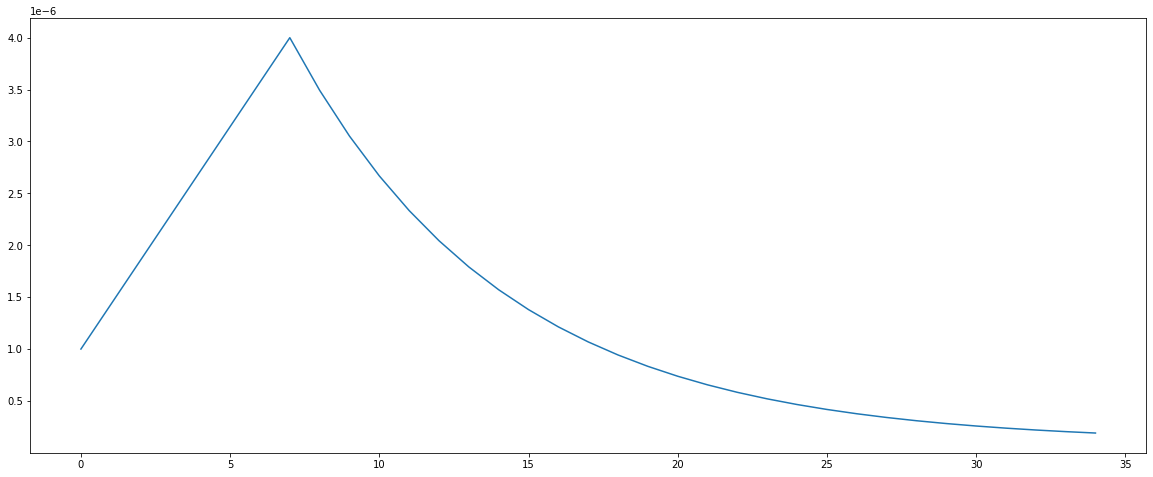

In [6]:
LR_START = 0.000001
LR_MIN = 0.0000001
LR_MAX = 0.000004
LR_RAMPUP_EPOCHS = 7
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .87

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
def model_fn():
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    base_model = TFBertModel.from_pretrained(base_model_path, config=config_path)
    sequence_output = base_model(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    x = Dropout(0.35)(cls_token)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
#                   loss=losses.BinaryCrossentropy(), 
                  loss=focal_loss(gamma=1.5), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

with strategy.scope():
    model = model_fn()
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 512, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 769       
Total params: 177,854,209
Trainable params: 177,854,209
Non-trainable params: 0
_________________________________________________________________


# Train

In [8]:
STEPS_PER_EPOCH = 150 #len(x_train) // BATCH_SIZE

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=1)

history = model.fit(x=get_training_dataset(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=get_validation_dataset(),
#                     callbacks=[es, lr_callback],
                    callbacks=[lr_callback],
                    epochs=EPOCHS, 
                    verbose=1).history

model.save_weights(model_path)

Train for 150 steps, validate for 125 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/35
150/150 [==============================] - 115s 768ms/step - loss: 0.0505 - binary_accuracy: 0.8821 - auc: 0.5372 - val_loss: 0.0537 - val_binary_accuracy: 0.8463 - val_auc: 0.5552

Epoch 00002: LearningRateScheduler reducing learning rate to 1.4285714285714286e-06.
Epoch 2/35
150/150 [==============================] - 37s 247ms/step - loss: 0.0361 - binary_accuracy: 0.9044 - auc: 0.6212 - val_loss: 0.0478 - val_binary_accuracy: 0.8463 - val_auc: 0.6576

Epoch 00003: LearningRateScheduler reducing learning rate to 1.857142857142857e-06.
Epoch 3/35
150/150 [==============================] - 37s 247ms/step - loss: 0.0304 - binary_accuracy: 0.9007 - auc: 0.8101 - val_loss: 0.0438 - val_binary_accuracy: 0.8474 - val_auc: 0.7358

Epoch 00004: LearningRateScheduler reducing learning rate to 2.285714285714286e-06.
Epoch 4/35
150/150 [==============================] - 37s

## Model loss graph

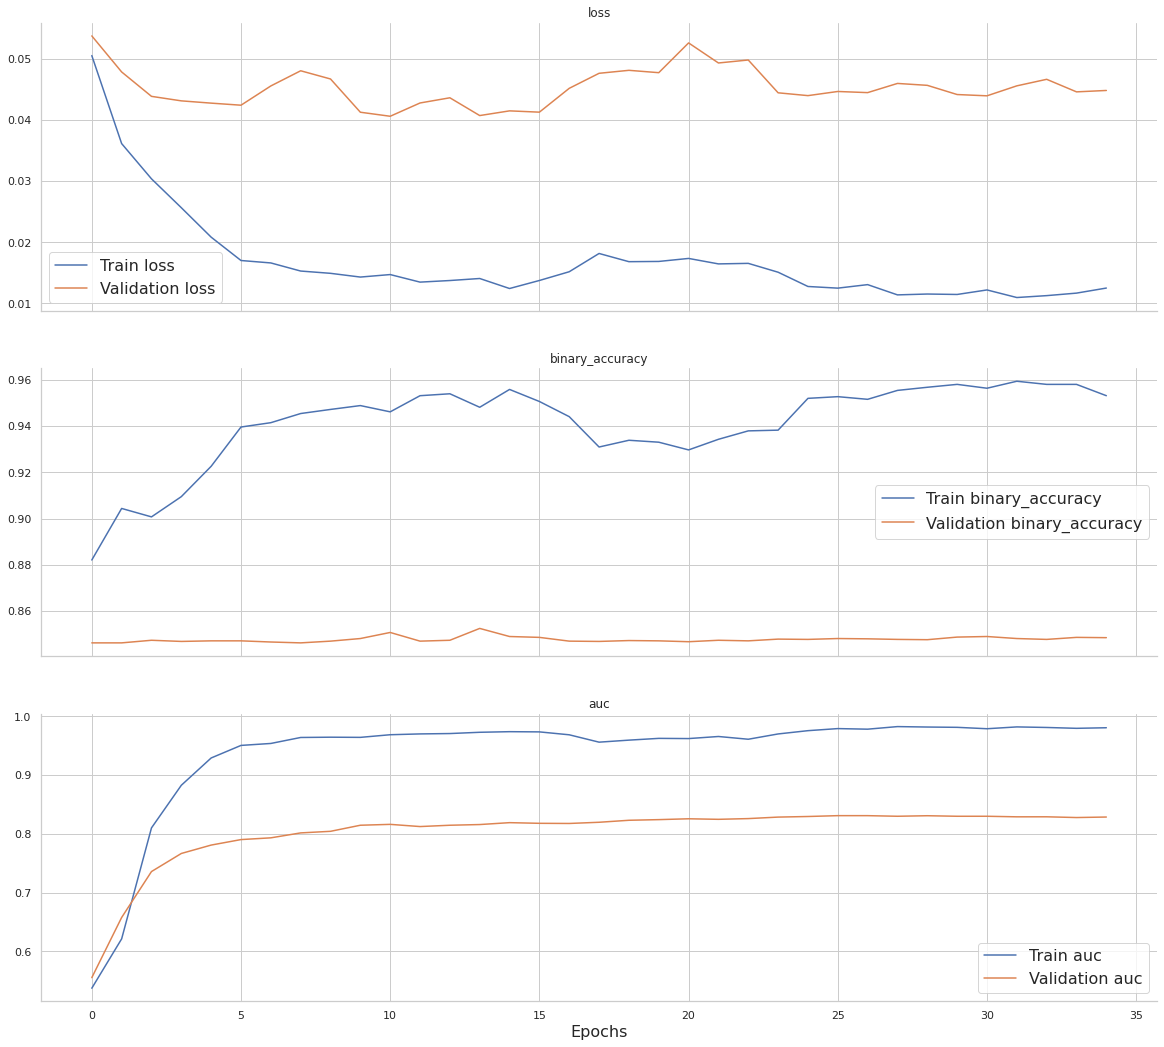

In [9]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'binary_accuracy', 'auc'])

# Model evaluation

In [10]:
train_pred = model.predict(get_training_dataset(), steps=TRAIN_STEPS)
valid_pred = model.predict(get_validation_dataset())
y_train = y_train[:len(train_pred)]
y_valid = y_valid[:len(valid_pred)]

print('Train set ROC AUC %.4f' % roc_auc_score(y_train, train_pred))
print(classification_report(y_train, np.round(train_pred)))
print('Validation set ROC AUC %.4f' % roc_auc_score(y_valid, valid_pred))
print(classification_report(y_valid, np.round(valid_pred)))

Train set ROC AUC 0.4987
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91    202107
         1.0       0.09      0.07      0.08     21381

    accuracy                           0.84    223488
   macro avg       0.50      0.50      0.50    223488
weighted avg       0.83      0.84      0.83    223488

Validation set ROC AUC 0.8286
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      6770
         1.0       0.69      0.03      0.05      1230

    accuracy                           0.85      8000
   macro avg       0.77      0.51      0.48      8000
weighted avg       0.82      0.85      0.78      8000



# Confusion matrix

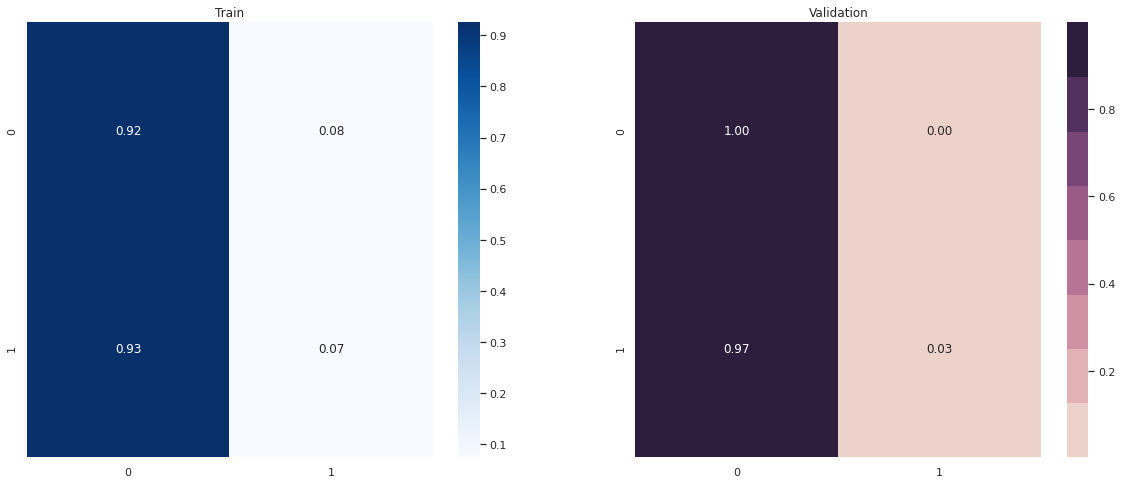

In [11]:
plot_confusion_matrix(y_train, np.round(train_pred), y_valid, np.round(valid_pred))

# Visualize predictions

In [12]:
train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv", 
                    usecols=['comment_text', 'toxic'], nrows=10)
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv', 
                    usecols=['comment_text', 'toxic'], nrows=10)
train['pred'] = train_pred[:len(train)]
valid['pred'] = valid_pred[:len(valid)]

print('Train set')
display(train[['comment_text', 'toxic', 'pred']].head(10))
print('Validation set')
display(valid[['comment_text', 'toxic', 'pred']].head(10))

Train set


,comment_text,toxic,pred
0,Explanation\nWhy the edits made under my usern...,0,0.224945
1,D'aww! He matches this background colour I'm s...,0,0.023736
2,"Hey man, I'm really not trying to edit war. It...",0,0.019722
3,"""\nMore\nI can't make any real suggestions on ...",0,0.021199
4,"You, sir, are my hero. Any chance you remember...",0,0.054548
5,"""\n\nCongratulations from me as well, use the ...",0,0.048330
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0.018351
7,Your vandalism to the Matt Shirvington article...,0,0.021742
8,Sorry if the word 'nonsense' was offensive to ...,0,0.295660
9,alignment on this subject and which are contra...,0,0.014335


Validation set


,comment_text,toxic,pred
0,Este usuario ni siquiera llega al rango de ...,0,0.089900
1,Il testo di questa voce pare esser scopiazzato...,0,0.057435
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,1,0.105151
3,Bu maddenin alt başlığı olarak uluslararası i...,0,0.068691
4,Belçika nın şehirlerinin yanında ilçe ve belde...,0,0.143502
5,"güzel, zaten kaynaklandırması zor subjektif ka...",0,0.129539
6,"No es mala idea. De hecho, yo estaba pensando ...",0,0.050203
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık ç...",0,0.141734
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umar...,0,0.173828
9,Creo que es importante que podamos reconocer a...,0,0.047011
